In [1]:
import pandas as pd
import numpy as np
import skimage.io as sk
from skimage import img_as_ubyte
from skimage.io import imread
from scipy import spatial
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [3]:

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
Image_Size = (256, 256)
Image_Channel = 3
train_path = '/content/drive/My Drive/Real-Forg-Signature/Train'
test_path = '/content/drive/My Drive/Real-Forg-Signature/Test'

In [6]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(), Dropout(0.3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(), Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'), Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,764,545 (60.14 MB)

 Trainable params: 15,764,545 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=15, shear_range=0.1,
                                     zoom_range=0.2, horizontal_flip=True,
                                     width_shift_range=0.1, height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=Image_Size, batch_size=16,
    class_mode='binary', classes=['Forge', 'Real']
)

test_generator = test_datagen.flow_from_directory(
    test_path, target_size=Image_Size, batch_size=16,
    class_mode='binary', classes=['Forge', 'Real']
)

Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
true_classes = test_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(true_classes),
    y=true_classes
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weights_dict)

Class weights: {0: 1.0, 1: 1.0}


In [9]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1)
callbacks = [early_stop, reduce_lr]

In [10]:
history = model.fit(
    train_generator, validation_data=test_generator,
    epochs=20, callbacks=callbacks,
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 134s 10s/step - accuracy: 0.4283 - loss: 5.9337 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5541 - loss: 0.6787 - val_accuracy: 0.5000 - val_loss: 0.6916 - learning_rate: 0.0010
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5259 - loss: 0.6858 - val_accuracy: 0.5000 - val_loss: 0.6811 - learning_rate: 0.0010
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6737 - loss: 0.6429 - val_accuracy: 0.5000 - val_loss: 0.5870 - learning_rate: 0.0010
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.7860 - loss: 0.4986 - val_accuracy: 0.5000 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.8207 - loss: 0.3946 - val_accuracy: 0.8600 - val_loss: 0.3171 - learning_rate: 0.0010
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9236 - loss: 0.2038 - val_accuracy

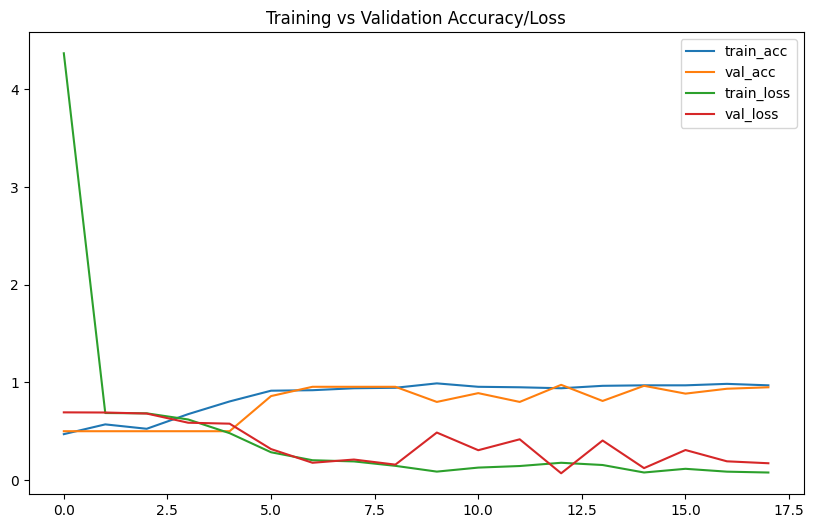

In [11]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Training vs Validation Accuracy/Loss'); plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Classification Report:

              precision    recall  f1-score   support

       Forge       0.53      0.53      0.53       100
        Real       0.53      0.53      0.53       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200



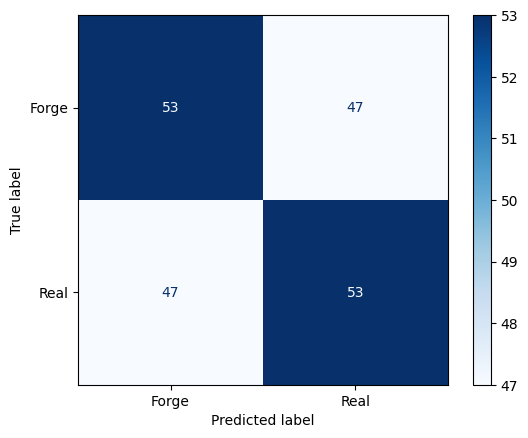

In [12]:
test_generator.reset()
pred_prob = model.predict(test_generator, verbose=1)
threshold = 0.4
pred_classes = (pred_prob > threshold).astype('int32').flatten()
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("Classification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues'); plt.show()

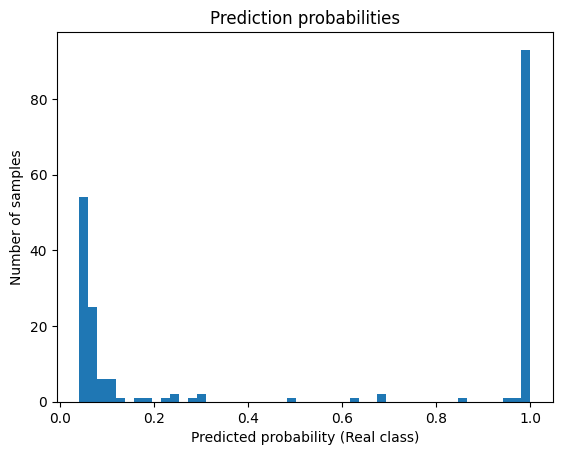

In [13]:

plt.hist(pred_prob, bins=50)
plt.title("Prediction probabilities")
plt.xlabel("Predicted probability (Real class)")
plt.ylabel("Number of samples")
plt.show()

In [14]:
model.save('real_forge_signature_binary_model.h5')